In [1]:
import os
if not os.path.exists("/scratch/sanika"):
    os.makedirs("/scratch/sanika")

os.environ["HF_HOME"] = "/scratch/sanika/"

In [2]:
from datasets import load_dataset

In [3]:
import torch
import torch.nn.functional as F
# from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from typing import List, Tuple, Optional
import time
import numpy as np
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
# set random seed
torch.manual_seed(42)
import torch.nn as nn

In [28]:
class OnlineSpeculativeDecoder:
    def __init__(
        self,
        target_model_name = "t5-large",
        draft_model_name = "t5-small",
        gamma = 4,
        update_interval=4,
    ):
        self.gamma = gamma
        self.update_interval = update_interval
        self.last_update_time = time.time()

        self.tokenizer = AutoTokenizer.from_pretrained(target_model_name)
        self.target_model = AutoModelForSeq2SeqLM.from_pretrained(target_model_name, device_map="auto")


        config = LoraConfig(
            r = 16,
            lora_alpha = 16,
            target_modules = ["q", "v"],
            lora_dropout = 0.5,
            bias = "lora_only",
            modules_to_save=["decode_head"]
        )
        draft_model = AutoModelForSeq2SeqLM.from_pretrained(draft_model_name, device_map="auto")

        self.draft_model = get_peft_model(draft_model, config)


        self.target_model.eval()
        self.draft_model.eval()

        self.replay_buffer = []
        self.temp_buffer = [] 

        # Counter for iteration tracking
        self.iteration_count = 0

        self.padding_length = 128

        self.acceptance_rate = []

        self.time_taken = []

        self.optimizer = torch.optim.Adam(self.draft_model.parameters(), lr=1e-4)
        self.loss = nn.CrossEntropyLoss()

    def get_draft_logits(
            self,
            input_ids: torch.Tensor,
            attention_mask: torch.Tensor,
            decoder_input_ids: torch.Tensor,
            gamma: int
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get draft logits for gamma tokens"""
        draft_tokens = []
        draft_probs = []
        current_decoder_ids = decoder_input_ids

        # Generate gamma tokens from the draft model
        for _ in range(gamma):
            with torch.no_grad():
                outputs = self.draft_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    decoder_input_ids=current_decoder_ids,
                    return_dict=True
                )
                logits = outputs.logits[:, -1, :]  # Get logits for last position
                probs = F.softmax(logits, dim=-1)

                # Sample token
                token_id = torch.multinomial(probs, num_samples=1).squeeze(-1)
                prob = probs.gather(-1, token_id.unsqueeze(-1)).squeeze(-1)

                draft_tokens.append(token_id.item())
                draft_probs.append(prob.item())

                # Update decoder inputs for next iteration
                current_decoder_ids = torch.cat(
                    [current_decoder_ids, token_id.view(1, 1)],
                    dim=1
                )

                if token_id.item() == self.tokenizer.eos_token_id:
                    break

        return draft_tokens, draft_probs, current_decoder_ids, outputs.logits

    def get_target_probs(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        decoder_input_ids: torch.Tensor,
        draft_tokens: torch.Tensor
    ) -> torch.Tensor:
        """Get target probabilities for the draft tokens in parallel."""
        with torch.no_grad():
            # Add draft tokens to decoder input
            full_decoder_ids = torch.cat([decoder_input_ids, draft_tokens.unsqueeze(0)], dim=1)

            outputs = self.target_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=full_decoder_ids,
                return_dict=True
            )

            # Get probabilities for positions before each draft token
            logits = outputs.logits[:, -(len(draft_tokens) + 1):-1, :]
            target_probs = F.softmax(logits, dim=-1)

            return target_probs.squeeze(0), outputs.logits
        
    def get_logits(self, model, input_ids, attention_mask, decoder_input_ids):
        return model(
            input_ids=input_ids,
            decoder_input_ids=decoder_input_ids,
            attention_mask=attention_mask,
        ).logits

    def verify_tokens(
        self,
        target_probs: torch.Tensor,
        draft_tokens: torch.Tensor,
        draft_probs: torch.Tensor,
    ) -> int:
        """Determine number of accepted tokens"""
        # Get target probabilities for the draft tokens
        target_probs_draft_tokens = target_probs.gather(
            -1,
            draft_tokens.unsqueeze(-1)
        ).squeeze(-1)

        # Calculate acceptance ratios
        acceptance_ratios = target_probs_draft_tokens.float() / draft_probs

        # Sample uniform random numbers 
        random_nums = torch.zeros_like(target_probs_draft_tokens).float().uniform_()

        mask = random_nums > acceptance_ratios
        num_accepted = (mask.cumsum(dim = -1) == 0).sum(dim = -1)

        return num_accepted.int().item()

    def pad_to_2d(self, tensor_list, pad_token_id, max_len=None):
        if not isinstance(tensor_list[0], torch.Tensor):
            tensor_list = [torch.tensor(t).reshape(1, -1) for t in tensor_list]
        if max_len is None:
            max_len = max([t.shape[-1] for t in tensor_list])
        assert max_len > 0

        # Pad each tensor to the max length and stack them to form a 2D tensor
        result = torch.cat(
            [
                torch.nn.functional.pad(
                    tensor, (0, max_len - tensor.shape[-1]),
                    value=pad_token_id
                )
                for tensor in tensor_list
            ],
            dim=0
        )
        return result
        

    def soft_cross_entropy(self, predicts, targets, padding_mask=None):
        predict_log_prob = torch.nn.functional.log_softmax(predicts, dim=-1)
        targets_prob = torch.nn.functional.softmax(targets, dim=-1)
        entropy = -targets_prob * predict_log_prob
        expand_mask = padding_mask.unsqueeze(-1).expand_as(entropy)
        entropy.masked_fill_(expand_mask, 0)
        mean_entropy = entropy.sum() / (~padding_mask).sum()
        return mean_entropy

    def translate_dataset(
        self,
        sentences: List[str],
        max_length: int = 128
    ) -> List[str]:
        """Translate dataset using online speculative decoding."""

        self.iteration_count = 0
        self.replay_buffer = []

        translated_data = []

        for i in tqdm(range(len(sentences))):

            start_time = time.time()

            source_text = sentences[i]
            accepted = 0
            total_windows = 0

            encoder_inputs = self.tokenizer(
                f"translate English to German: {source_text}",
                return_tensors="pt",
                padding=True
            )

            # Initialize with start token
            decoder_input_ids = torch.tensor([[self.tokenizer.pad_token_id]])
            self.temp_buffer = []

            while decoder_input_ids.shape[1] < max_length:

                # Check for end of sequence
                if decoder_input_ids[0][-1].item() == self.tokenizer.eos_token_id:
                    break

                total_windows += 1

                # Get draft tokens autoregressively
                # print("Encoder Inputs", encoder_inputs.input_ids.shape)
                draft_tokens, draft_probs, proposed_decoder_ids, draft_logits = self.get_draft_logits(
                    encoder_inputs.input_ids,
                    encoder_inputs.attention_mask,
                    decoder_input_ids,
                    self.gamma
                )

                draft_tokens = torch.tensor(draft_tokens)
                draft_probs = torch.tensor(draft_probs)

                if len(draft_tokens) == 0:
                    break

                # Get target probabilities in parallel
                target_probs, target_logits = self.get_target_probs(
                    encoder_inputs.input_ids,
                    encoder_inputs.attention_mask,
                    decoder_input_ids,
                    draft_tokens
                )

                # print("Iteration")

                # Verify tokens
                n_accepted = self.verify_tokens(target_probs, draft_tokens, draft_probs)

                if n_accepted > 0:
                    decoder_input_ids = torch.cat([
                        decoder_input_ids,
                        draft_tokens[:n_accepted].unsqueeze(0)
                    ], dim=1)

                n_rejected = self.gamma - n_accepted
                accepted += n_accepted

                # print("Rejected", n_rejected)

                with torch.no_grad():
                    if n_rejected > 0:
                        probs = target_logits[:, -n_rejected, :]

                    else:
                        probs = target_logits[:, -1, :]
                    probs = F.softmax(probs, dim=-1)
                    token_id = torch.multinomial(probs, num_samples=1)
                    decoder_input_ids = torch.cat([decoder_input_ids, token_id], dim=1)
                
                # rejected_tokens = draft_tokens[n_accepted]
                if n_accepted < len(draft_tokens):

                    self.temp_buffer.append((encoder_inputs, decoder_input_ids, target_logits, n_accepted))
            
            end_time = time.time()
            self.time_taken.append(end_time - start_time)

            self.acceptance_rate.append(accepted / (total_windows * self.gamma))

            self.replay_buffer.extend(self.temp_buffer)
            self.iteration_count += 1

            # decode the decoder input ids
            translation = self.tokenizer.decode(
                decoder_input_ids[0],
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True
            )

            if self.iteration_count % self.update_interval == 0:
                # self.update_draft_model()
                self.draft_model.train()
                
                # finetune over collected tokens and logits

                # x[0] is encoder input, x[1] is decoder input, x[2] is target logits, x[3] is n_accepted
                encoder_input_ids = self.pad_to_2d([x[0].input_ids for x in self.replay_buffer], 0)
                # shape is replay_buffer_size, max_length of the sentences

                # pad attention mask with 0s to get the same shape
                max_sentence_length = max([x[0].attention_mask[0].shape[0] for x in self.replay_buffer])
                padded_attention_mask = []
                for i in range(len(self.replay_buffer)):
                    temp = torch.zeros(max_sentence_length, dtype=torch.bool)
                    temp[:self.replay_buffer[i][0].attention_mask[0].shape[0]] = self.replay_buffer[i][0].attention_mask[0]
                    padded_attention_mask.append(temp)

                encoder_attention_mask = torch.stack(padded_attention_mask, dim=0)

                decoder_input_ids = self.pad_to_2d([x[1] for x in self.replay_buffer], 0, self.padding_length)


                target_logits = [x[2] for x in self.replay_buffer]
                for i in range(len(target_logits)):
                    temp = torch.zeros(1, 32128).repeat(self.padding_length - target_logits[i].shape[1], 1).unsqueeze(0)
                    target_logits[i] = torch.cat([target_logits[i], temp], dim=1)

                n_accepted_tokens = [x[3] for x in self.replay_buffer]

                # CUDA out of memory error
                draft_logits = self.get_logits(self.draft_model, encoder_input_ids, encoder_attention_mask, decoder_input_ids).float()

                # need to get loss only using the wrong tokens
                # TODO: check if we need to ignore the pad tokens in the mask
                mask = torch.ones_like(decoder_input_ids, dtype=torch.bool)
                for i in range(len(n_accepted_tokens)):
                    mask[i, n_accepted_tokens[i]:] = False
                
                # stack target logits
                # target_logits = torch.stack(target_logits, dim=0)
                # print(target_logits.shape)
                # target_logits = torch.argmax(target_logits, dim=-1)
                # print(target_logits.shape)

                # print(draft_logits.shape)
                # print(target_logits[0].shape)
                target_logits = torch.stack(target_logits, dim=0)
                target_logits = target_logits.squeeze(1)    

                loss = self.soft_cross_entropy(draft_logits, target_logits, mask)
                print(loss)
                # print(draft_logits.shape)
                # print(target_logits[0].shape)
                # loss = self.loss(draft_logits.view(-1, 32128), target_logits[0].view(-1, 32128))
                loss.backward()
                self.optimizer.step()

                self.optimizer.zero_grad()
                self.draft_model.eval()

                # print the number of accepted tokens
                print(f"Iteration {self.iteration_count}: Accepted rate: {self.acceptance_rate[-1]}")
            


                self.draft_model.eval()
                self.replay_buffer = []
                self.iteration_count = 0

            translated_data.append(translation)
        return translated_data

## Dataset stuff

In [15]:
dataset = load_dataset('wmt16', 'de-en', split='validation')

In [16]:
# make a set of all the english sentences
english_sentences = [x['translation']['en'] for x in dataset]

In [30]:
english_sentences = english_sentences[:5]
english_sentences = english_sentences + english_sentences

In [31]:
# training
online_decoder = OnlineSpeculativeDecoder()
translation = online_decoder.translate_dataset(english_sentences)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 30%|███       | 3/10 [00:25<01:04,  9.18s/it]

tensor(16.3127, grad_fn=<DivBackward0>)


 40%|████      | 4/10 [00:31<00:45,  7.57s/it]

Iteration 4: Accepted rate: 0.25


 70%|███████   | 7/10 [00:44<00:17,  5.85s/it]

tensor(16.7727, grad_fn=<DivBackward0>)


 80%|████████  | 8/10 [00:50<00:11,  5.95s/it]

Iteration 4: Accepted rate: 0.4107142857142857


100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


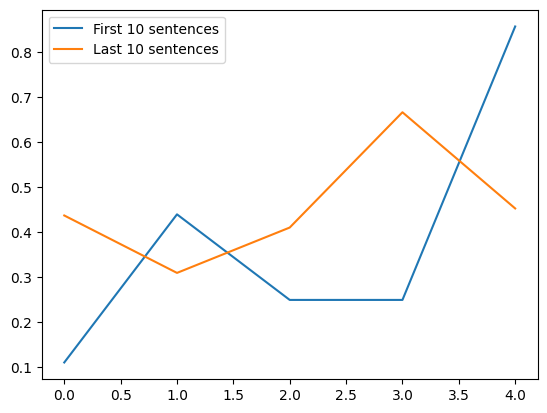

In [ ]:
first = online_decoder.acceptance_rate[:5]
last = online_decoder.acceptance_rate[-5:]



import matplotlib.pyplot as plt

plt.plot(first)
plt.plot(last)
plt.legend(["First 10 sentences", "Last 10 sentences"])
